In [2]:
#Importing the libraries
import torch
import torch.nn as nn #This helps us to create the neural network library
import torch.optim as optim #This class is used to apply Stochastic Gradient Descent
from torch.optim import lr_scheduler #This class is used to mainly adjust the learning rate
from torchvision import datasets, models, transforms #These classes are used to load the dataset, the images are rotated and transformed using this, also this helps us import the pretrained alexnet and resnet-18 models
import matplotlib.pyplot as plt #This library is used to plot the accuracy and loss curves
import time #This library is used to measure the time each model took to train
import copy

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),#The images are now made 224*224 pixel size
    transforms.RandomHorizontalFlip(), #This line of code randomly flips the images horizontally
    transforms.ToTensor(),#The images are converted to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #This helps to standardise each color channels.
])

#This section of code is mainly to just load the datatset
data_dir = './data'
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #This line of code enables the model to train itself either on the CPU or GPU whichever is available


100%|██████████| 170M/170M [00:05<00:00, 34.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
#This section of code basically sets up the parameters and imports the ResNet-18 model from
model = models.resnet18(pretrained=False) #This line of code tells python that we don't need to import a pre trained model
num_ftrs = model.fc.in_features #This line of code basically pushes the input images into the final fully connected layer
model.fc = nn.Linear(num_ftrs, 10)  #Since in the dataset, we have 10 classes so the orignal fully connected layer will also have 10 features
model = model.to(device) #This line of code basically tells the model to train itself using GPU or CPU

criterion = nn.CrossEntropyLoss() #For this model we will be evaluating it's performance using the Cross Entropy Loss Function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #I have applied stochastic gradient descent with the initial learning rate as 0.001 and the momentum is set as 0.9
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #This line of code basically multiplies the learning rate by 0.1 after every 7 epochs


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10): #We are running 10 epochs so the training class has a default parameter of 10.
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 #The accuracy is initialised as 0

    train_acc, val_acc = [], [] #After every epoch the accuracy will be stored in these lists
    train_loss, val_loss = [], [] #After every epoch the loss values will be stored in these lists
#This step is defining how an epoch is run
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
#This section helps to run the training phase and validation phase of an epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #This begins model training
            else:
                model.eval() #This begins model evaluation

            running_loss = 0.0
            running_corrects = 0

            #This is batch iteration
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                #This is the forward pass step and the loss is also calculated
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #This is the backward pass step for optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #The learning rate is updated here
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            #The best model is saved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')


    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, train_loss, val_loss


model, train_acc, val_acc, train_loss, val_loss = train_model(model, criterion, optimizer, scheduler, num_epochs=10)



Epoch 0/9
----------
train Loss: 1.5751 Acc: 0.4178
val Loss: 1.2848 Acc: 0.5347
Epoch 1/9
----------
train Loss: 1.1879 Acc: 0.5703
val Loss: 1.1334 Acc: 0.5972
Epoch 2/9
----------
train Loss: 0.9726 Acc: 0.6561
val Loss: 0.9354 Acc: 0.6723
Epoch 3/9
----------
train Loss: 0.8289 Acc: 0.7065
val Loss: 0.8781 Acc: 0.6982
Epoch 4/9
----------
train Loss: 0.7163 Acc: 0.7485
val Loss: 0.7148 Acc: 0.7491
Epoch 5/9
----------
train Loss: 0.6226 Acc: 0.7815
val Loss: 0.6981 Acc: 0.7550
Epoch 6/9
----------
train Loss: 0.5494 Acc: 0.8084
val Loss: 0.6716 Acc: 0.7659
Epoch 7/9
----------
train Loss: 0.4043 Acc: 0.8661
val Loss: 0.5277 Acc: 0.8152
Epoch 8/9
----------
train Loss: 0.3760 Acc: 0.8748
val Loss: 0.5254 Acc: 0.8203
Epoch 9/9
----------
train Loss: 0.3596 Acc: 0.8816
val Loss: 0.5295 Acc: 0.8152
Training complete in 31m 13s
Best val Acc: 0.820300


Text(0.5, 1.0, 'Training and Validation Loss')

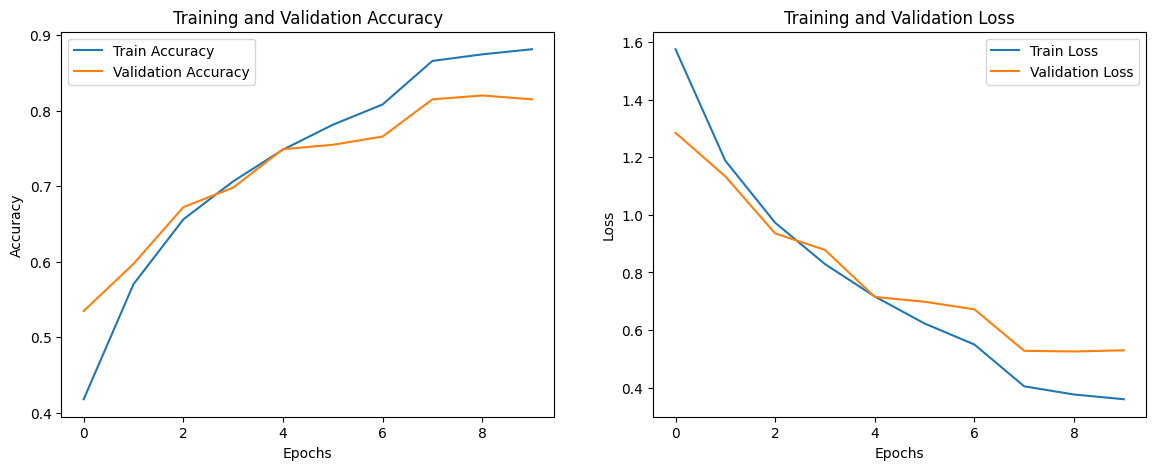

In [8]:
#Plotting the training v/s validation accuracy and loss curves
epochs = range(0, 10)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

In [9]:
#Importing the alexnet model
model = models.alexnet(pretrained=False)  #This line of code tells python that we don't need to import a pre trained model
num_ftrs = model.classifier[6].in_features #This line of code basically pushes the input images into the final fully connected layer
model.classifier[6] = nn.Linear(num_ftrs, 10)  #Since in the dataset, we have 10 classes so the orignal fully connected layer will also have 10 features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #This line of code basically tells the model to train itself using GPU or CPU
model = model.to(device)

criterion = nn.CrossEntropyLoss() #For this model we will be evaluating it's performance using the Cross Entropy Loss Function

#We have defined the training function here to run 10 epochs
def train_model_default(model, criterion, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 #The accuracy is initialised as 0

    train_acc, val_acc = [], [] #After every epoch the accuracy will be stored in these lists
    train_loss, val_loss = [], [] #After every epoch the loss will be stored in these lists
#This step is defining how an epoch is run
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        #This section helps to run the training phase and validation phase of an epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #This begins model training
            else:
                model.eval()   #This begins model evaluation

            running_loss = 0.0
            running_corrects = 0

            #This is batch iteration
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                #This is the forward pass step and the loss is also calculated here
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                  #Here the weights are updated in the training phase
                    if phase == 'train':
                        model.zero_grad()
                        loss.backward()
                        with torch.no_grad():
                            for param in model.parameters():
                                param -= 0.001 * param.grad  #Here, the learning rate is fixed to 0.001
                #Here the loss is calculated and added
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #Here, the loss and accuracy of the whole epoch is calculated
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())
          #We are saving the best model based on the accuracy obtained
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, train_loss, val_loss


model, train_acc, val_acc, train_loss, val_loss = train_model_default(model, criterion, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.3024 Acc: 0.1044
val Loss: 2.3020 Acc: 0.1590
Epoch 1/9
----------
train Loss: 2.3019 Acc: 0.1158
val Loss: 2.3013 Acc: 0.1645
Epoch 2/9
----------
train Loss: 2.3011 Acc: 0.1329
val Loss: 2.3000 Acc: 0.1820
Epoch 3/9
----------
train Loss: 2.2997 Acc: 0.1248
val Loss: 2.2973 Acc: 0.1256
Epoch 4/9
----------
train Loss: 2.2957 Acc: 0.1141
val Loss: 2.2884 Acc: 0.1239
Epoch 5/9
----------
train Loss: 2.2723 Acc: 0.1241
val Loss: 2.2002 Acc: 0.2239
Epoch 6/9
----------
train Loss: 2.0654 Acc: 0.2514
val Loss: 1.9338 Acc: 0.2963
Epoch 7/9
----------
train Loss: 1.9036 Acc: 0.3049
val Loss: 1.9460 Acc: 0.3174
Epoch 8/9
----------
train Loss: 1.7817 Acc: 0.3482
val Loss: 1.7333 Acc: 0.3645
Epoch 9/9
----------
train Loss: 1.6909 Acc: 0.3784
val Loss: 1.7590 Acc: 0.3753
Training complete in 20m 11s
Best val Acc: 0.375300


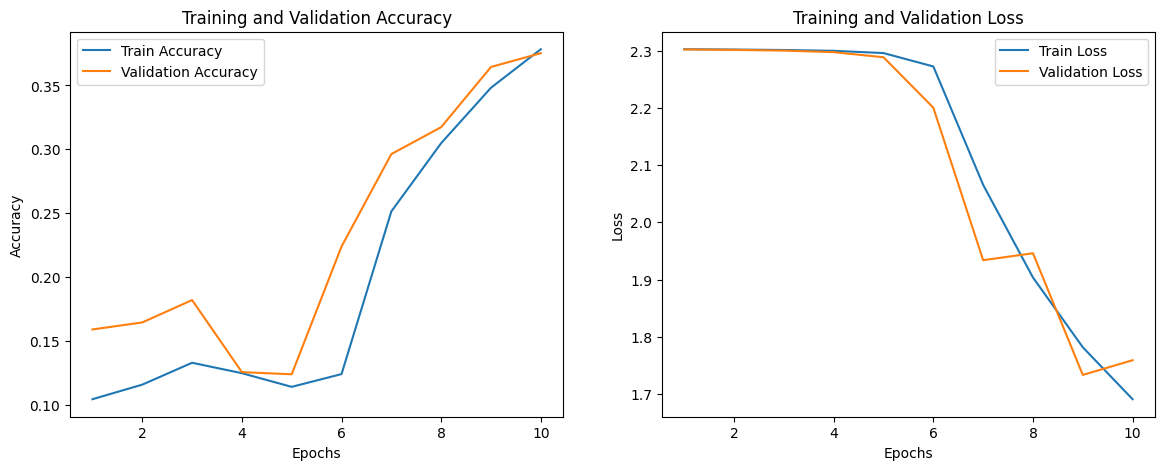

In [10]:
#Plotting the training v/s validation accuracy and loss curves
epochs = range(0, 10)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Display the plots
plt.show()